In [1]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

2023-06-02 15:44:41.461530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 15:44:42.674156: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-02 15:44:47.151947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-02 15:44:47.152213: W tensorflow/strea

tf.Tensor(105.559204, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### <font color=purple>Background of ResNet50</font>
- Resnet is a deep learning model that was developed with 50 layers deep. 
- The pretrained model on keras is build off the imagenet weights and can be used to build a pretrained model. However, when building this model, we are required to define our classes to 10 instead of 100/
- The model takes in an input size of 224,224,3 instead of 299 or 32. 

### <font color=purple>Why no keras preprocessing</font>
- In the keras documentaiton, we have noticed that the preprocessing only takes into consideration the image size and transforms the images. Furthermore, it does not scale, normalise or conduct any other form of preprocessing for the cifar10 dataset.
- Hence we will be making use of our own pre processing.

# <font color=maroon>Model Building (Baseline) - ResNet50
   

### Import

In [17]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [18]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 256
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>What are our parameters?</font>
- Set include top as false
- Set pre_model.trainable=False
- Created final dense layers ourselves

In [20]:
pre_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
pre_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [21]:
pre_model.trainable = False

In [24]:
# build resnet50 model
model = Sequential(name='ResNet50_Baseline')
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "ResNet50_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/20


2023-06-01 04:28:18.332040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-01 04:28:19.746795: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 04:28:19.747937: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 04:28:19.747994: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-01 04:28:19.749175: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-01 04:28:19.749293: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


196/196 [==============================] - 61s 265ms/step - loss: 2.2725 - accuracy: 0.1457 - val_loss: 2.2425 - val_accuracy: 0.1945
Epoch 2/20
196/196 [==============================] - 47s 241ms/step - loss: 2.1392 - accuracy: 0.2091 - val_loss: 2.0655 - val_accuracy: 0.2561
Epoch 3/20
196/196 [==============================] - 49s 250ms/step - loss: 2.0362 - accuracy: 0.2519 - val_loss: 2.0560 - val_accuracy: 0.2285
Epoch 4/20
196/196 [==============================] - 48s 244ms/step - loss: 1.9721 - accuracy: 0.2739 - val_loss: 1.9632 - val_accuracy: 0.2812
Epoch 5/20
196/196 [==============================] - 48s 245ms/step - loss: 1.9383 - accuracy: 0.2889 - val_loss: 1.9089 - val_accuracy: 0.3002
Epoch 6/20
196/196 [==============================] - 48s 247ms/step - loss: 1.9052 - accuracy: 0.3034 - val_loss: 1.9914 - val_accuracy: 0.2573
Epoch 7/20
196/196 [==============================] - 47s 242ms/step - loss: 1.8853 - accuracy: 0.3086 - val_loss: 1.8640 - val_accuracy: 0.3

In [25]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

40/40 [==============================] - 8s 196ms/step - loss: 1.7003 - accuracy: 0.3783
Test loss:  1.7002956867218018
Test accuracy: 0.3783000111579895


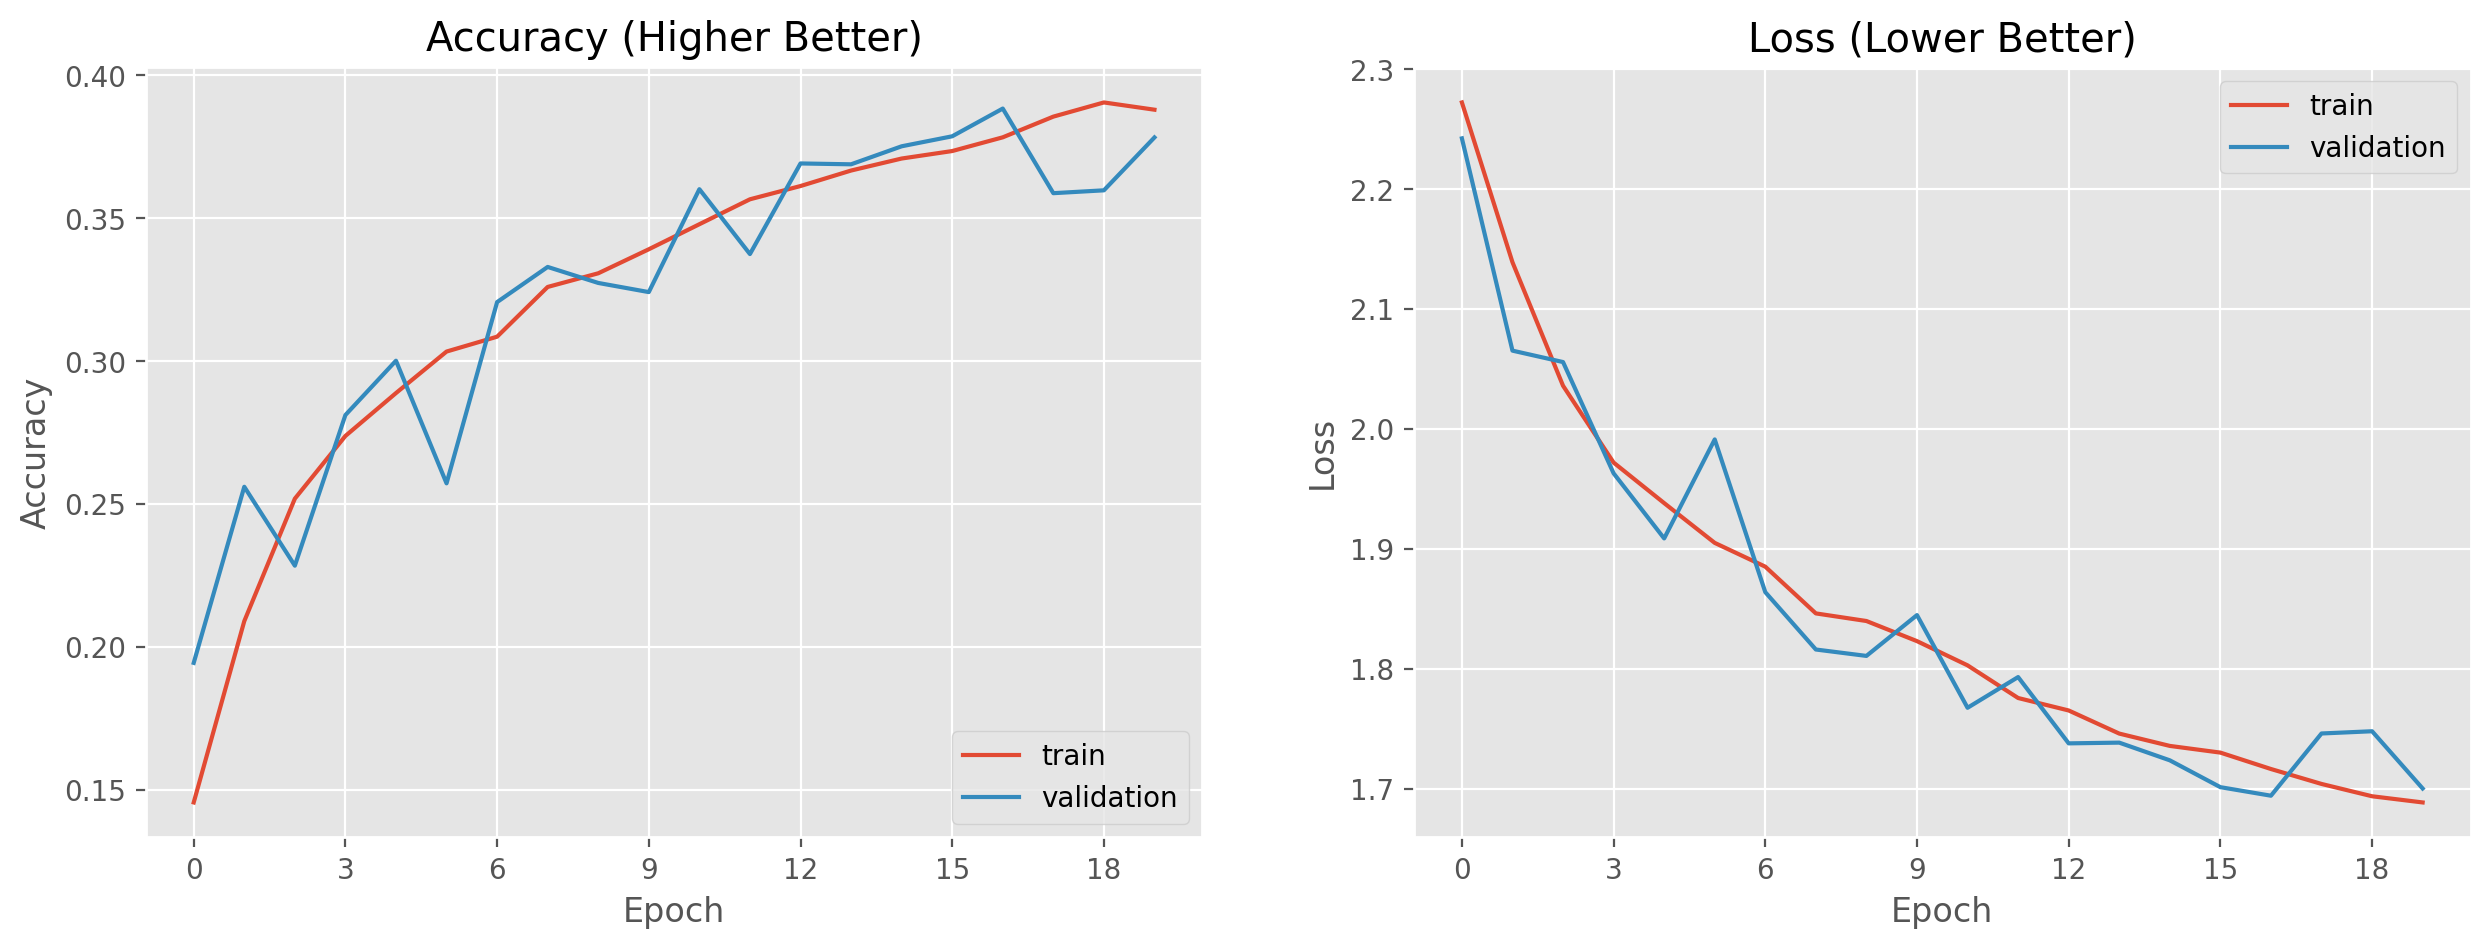

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [27]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

40/40 [==============================] - 9s 194ms/step
[6 8 8 ... 5 5 7]


In [28]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [29]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [30]:
print(err_x.shape)

(1000, 32, 32, 3)


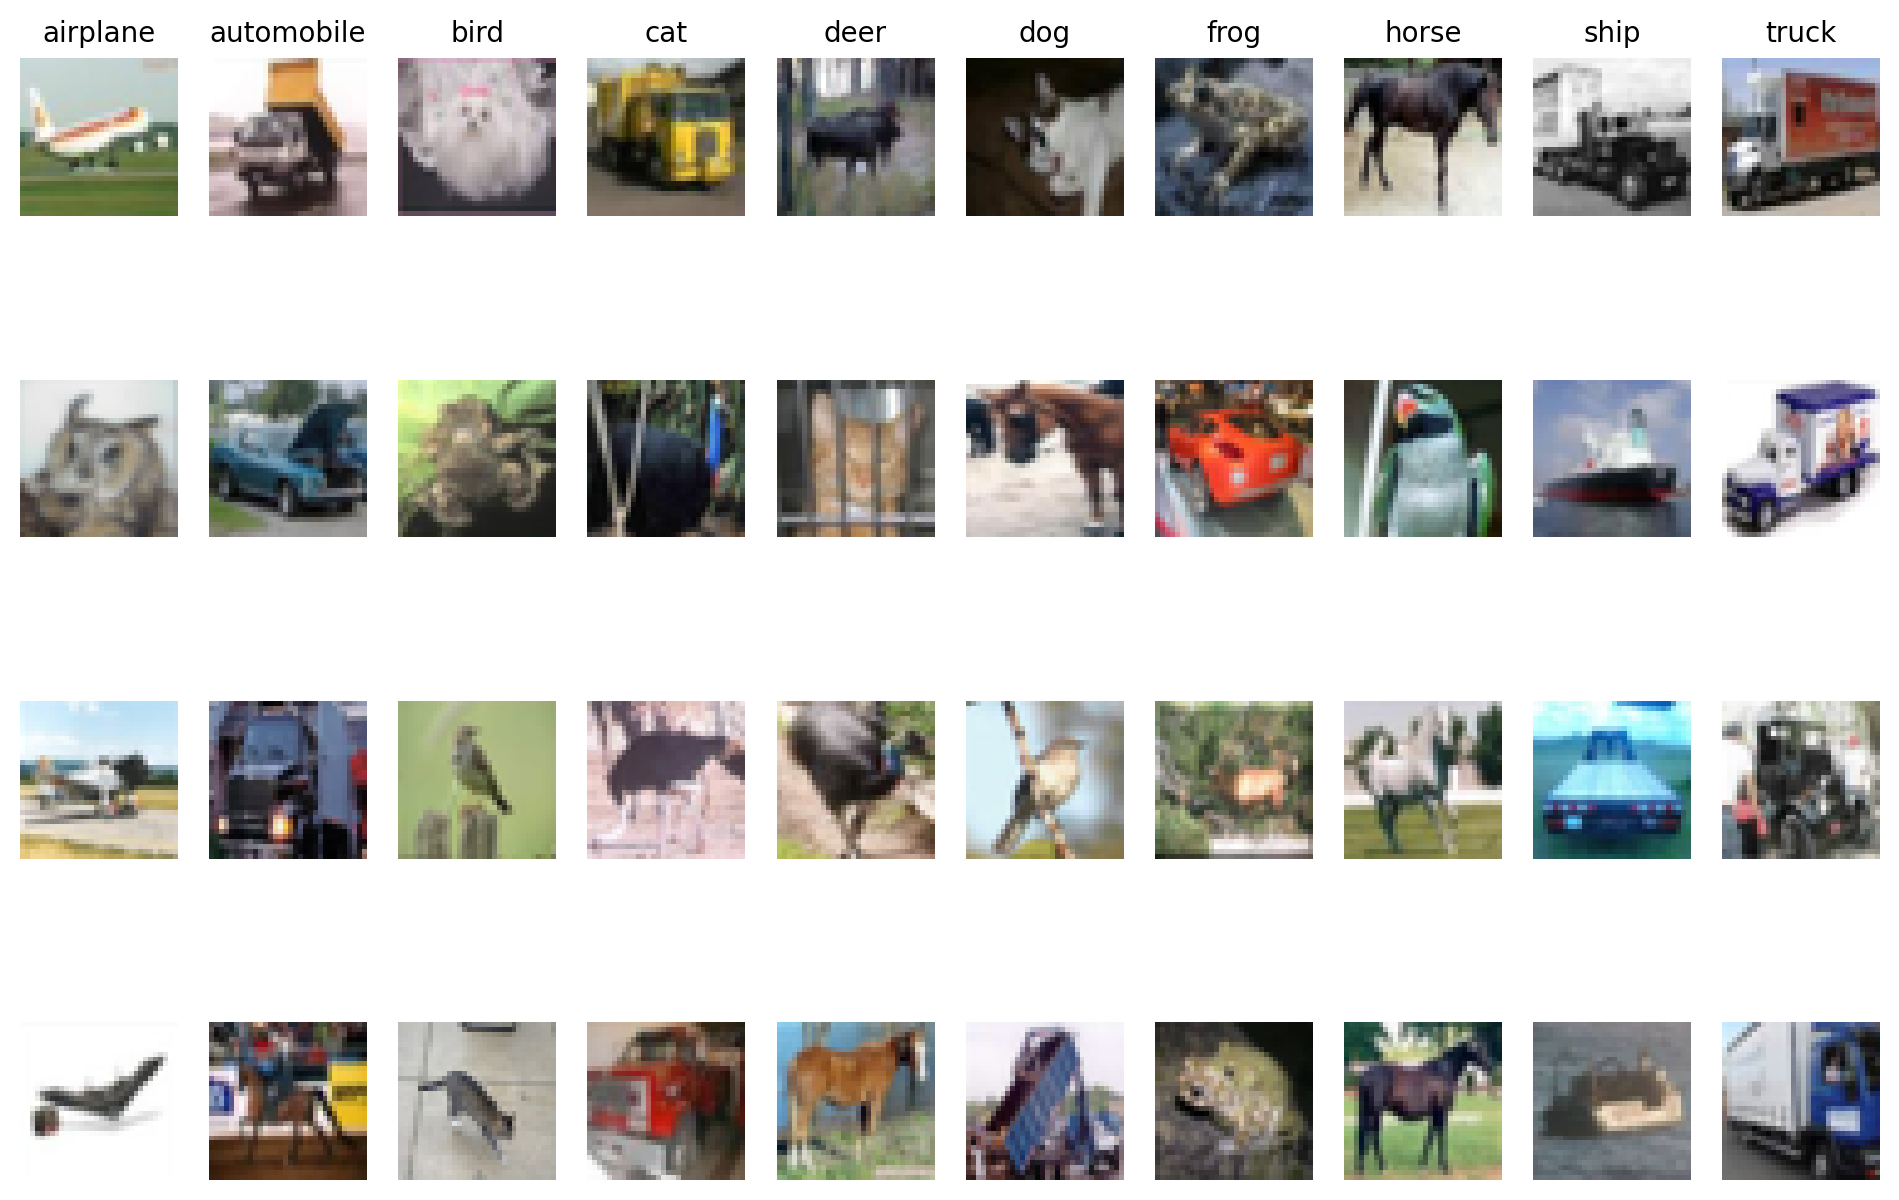

In [31]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Testing categorising on a single model

### Imports

In [32]:
import requests
from PIL import Image
from io import BytesIO

In [33]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [34]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [35]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [36]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 2s 2s/step


In [37]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [38]:
predicted_label = class_labels[predicted_class_index[0]]

In [39]:
print(predicted_label)


airplane


### <font color=maroon>Visualising confusion matrix

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [41]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [42]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.3783


In [43]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.4294848805191469
Recall: 0.3783
F1 Score: 0.3478313304813237


### Creating confusion matrix

In [44]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

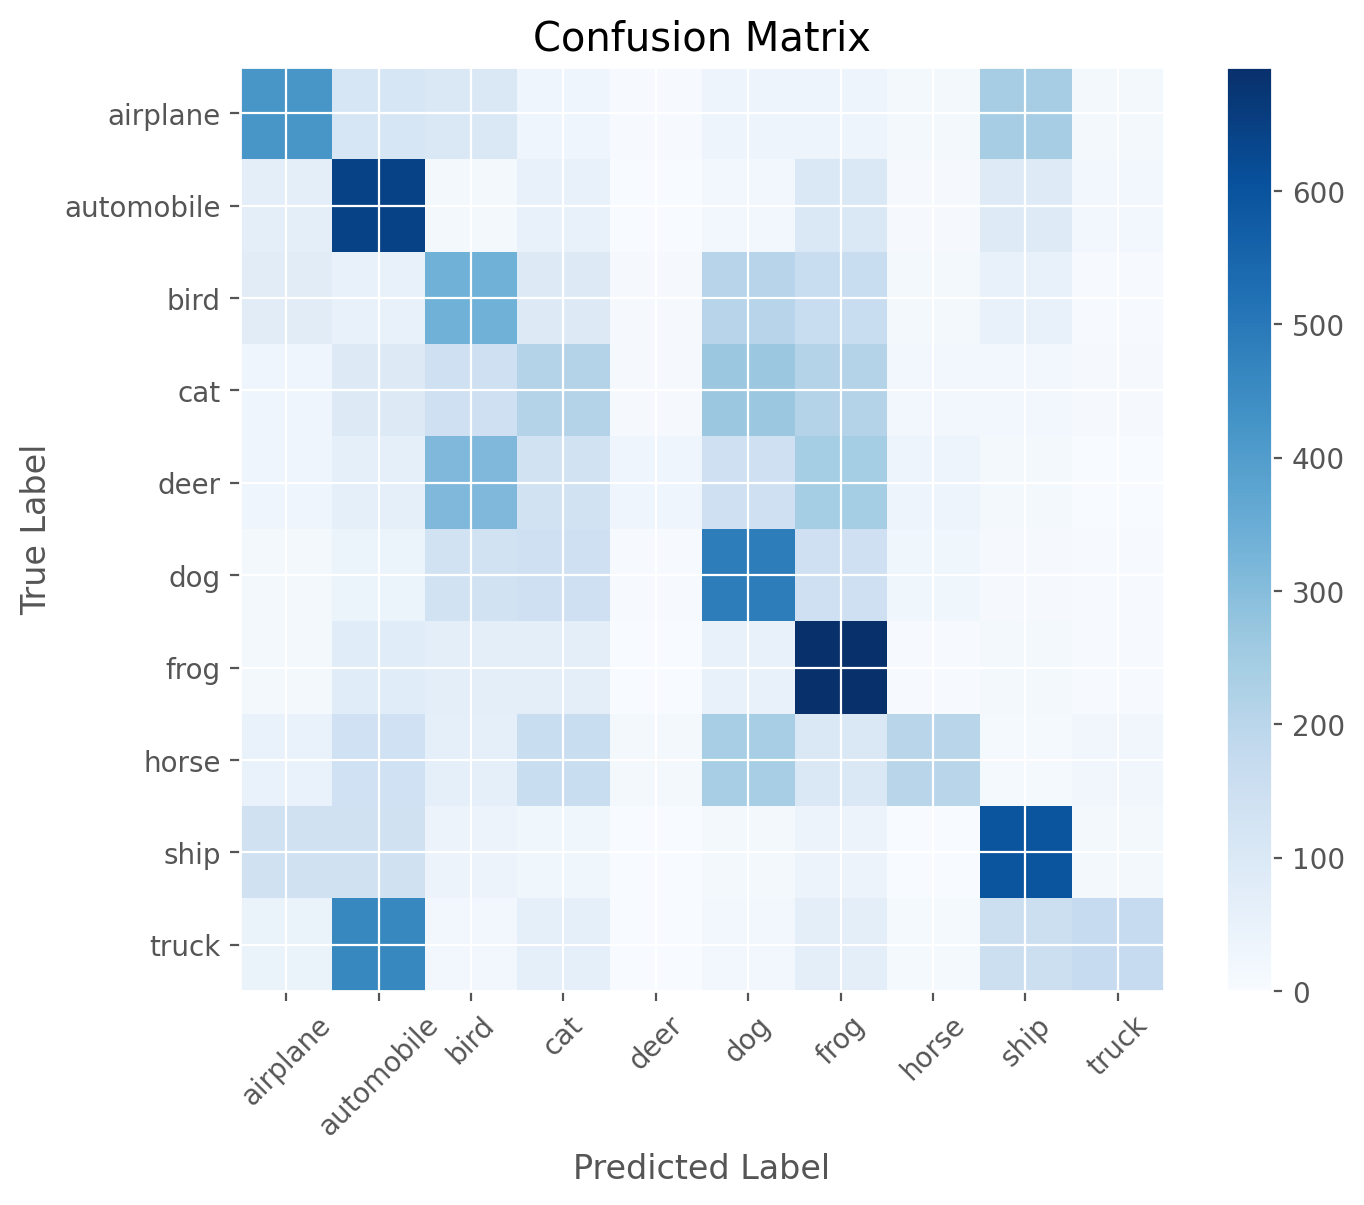

In [45]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [46]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.47      0.42      0.44      1000
  automobile       0.35      0.64      0.46      1000
        bird       0.27      0.34      0.30      1000
         cat       0.22      0.21      0.22      1000
        deer       0.48      0.03      0.05      1000
         dog       0.33      0.48      0.39      1000
        frog       0.39      0.69      0.50      1000
       horse       0.61      0.20      0.30      1000
        ship       0.50      0.59      0.54      1000
       truck       0.67      0.17      0.27      1000

    accuracy                           0.38     10000
   macro avg       0.43      0.38      0.35     10000
weighted avg       0.43      0.38      0.35     10000



# <font color=maroon>Model Building Tuned 1 - ResNet50
   

### Import

In [48]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [49]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 256
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>What are our parameters?</font>
- Set include top as false
- Set pre_model.trainable=False
- Added class parameter and increased dense layer number of neurons

In [50]:
pre_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', classes=10)
pre_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [51]:
pre_model.trainable = False

In [52]:
# build resnet50 model
model = Sequential(name='ResNet50_Tuned_1')
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(4098, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "ResNet50_Tuned_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4098)              8396802   
                                                                 
 dense_5 (Dense)             (None, 10)                40990     
                                                                 
Total params: 32,025,504
Trainable params: 8,437,792
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 54s 249ms/step - loss: 2.3067 - accuracy: 

In [53]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

40/40 [==============================] - 8s 196ms/step - loss: 1.6135 - accuracy: 0.4066
Test loss:  1.6135075092315674
Test accuracy: 0.4065999984741211


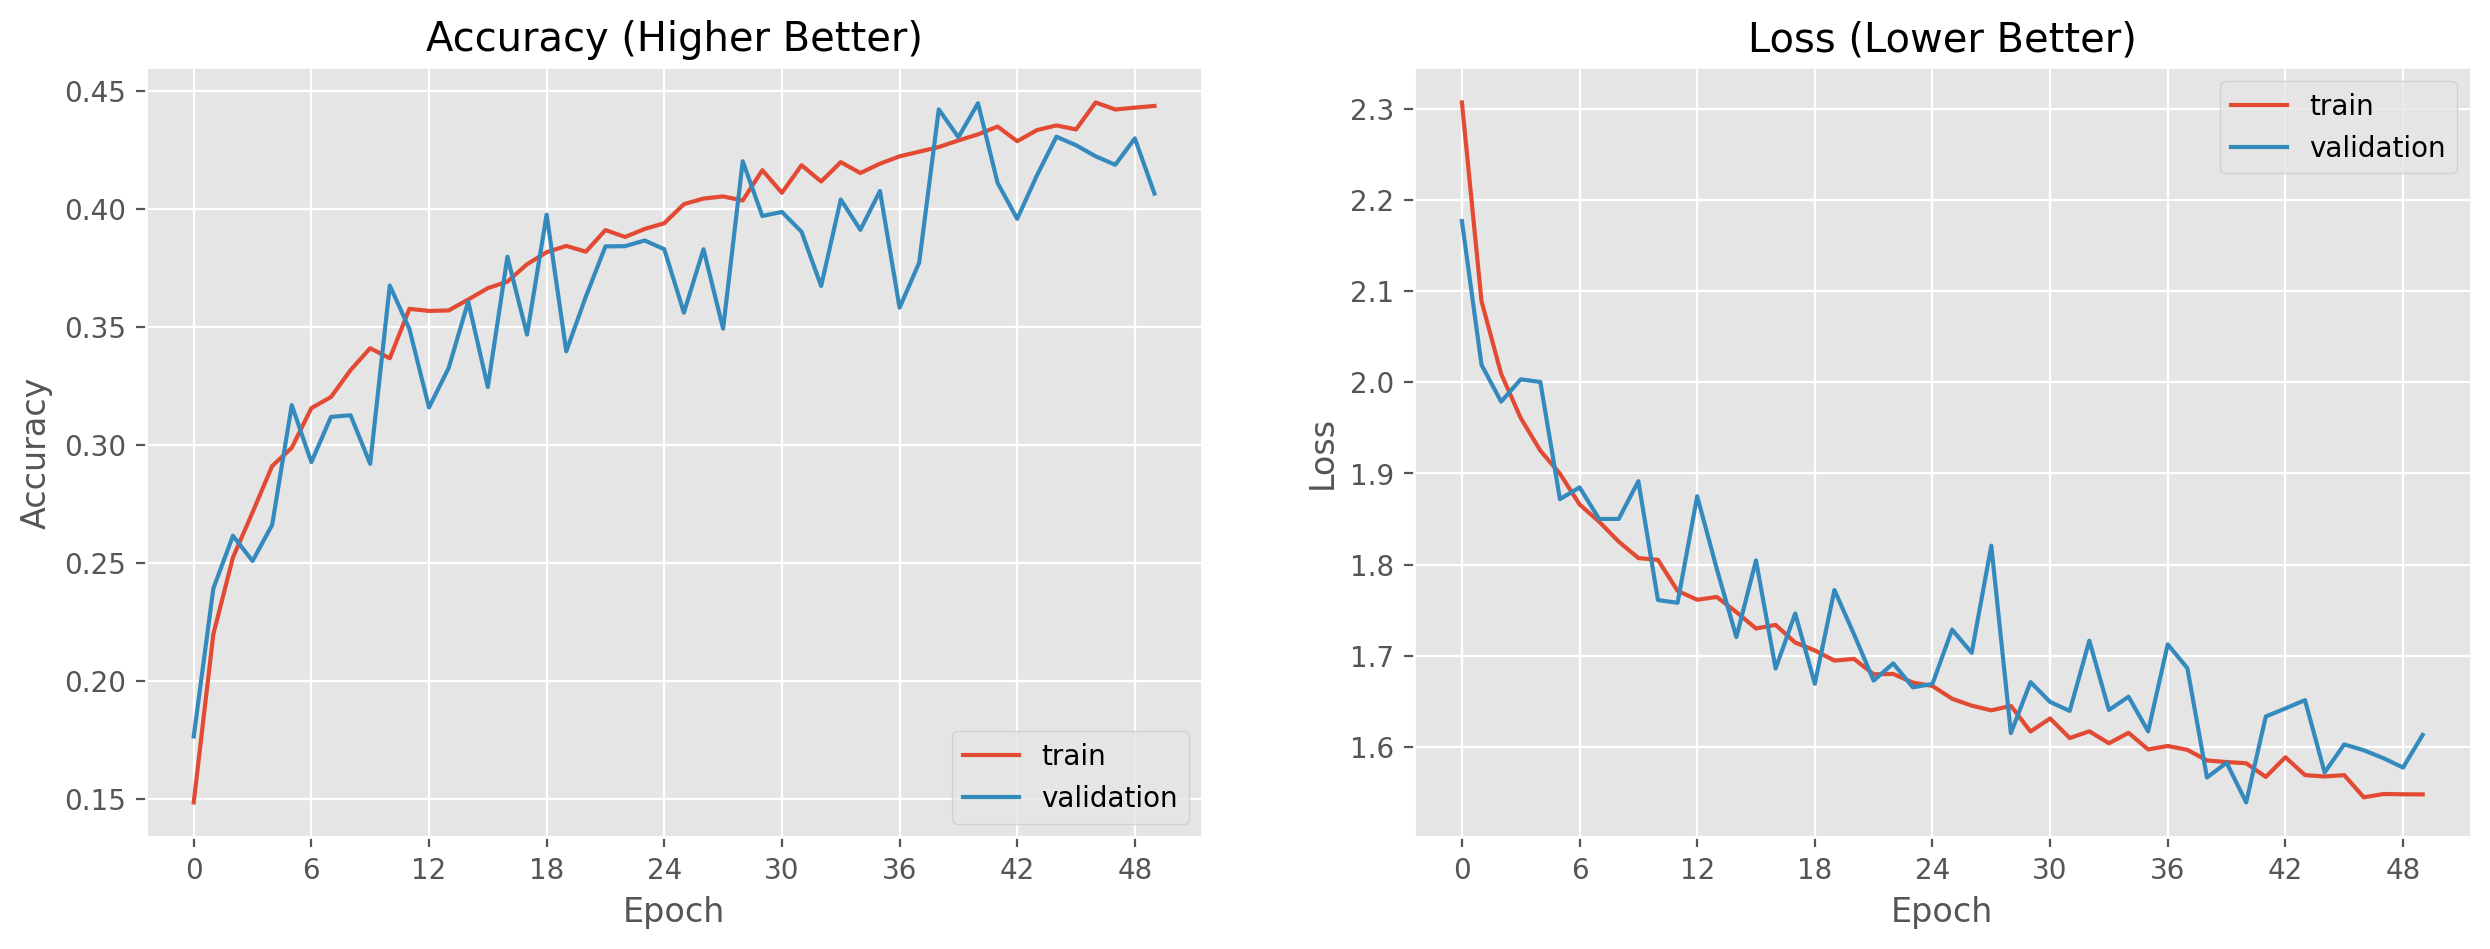

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [55]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

40/40 [==============================] - 9s 193ms/step
[9 8 8 ... 5 3 7]


In [56]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [57]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [58]:
print(err_x.shape)

(1000, 32, 32, 3)


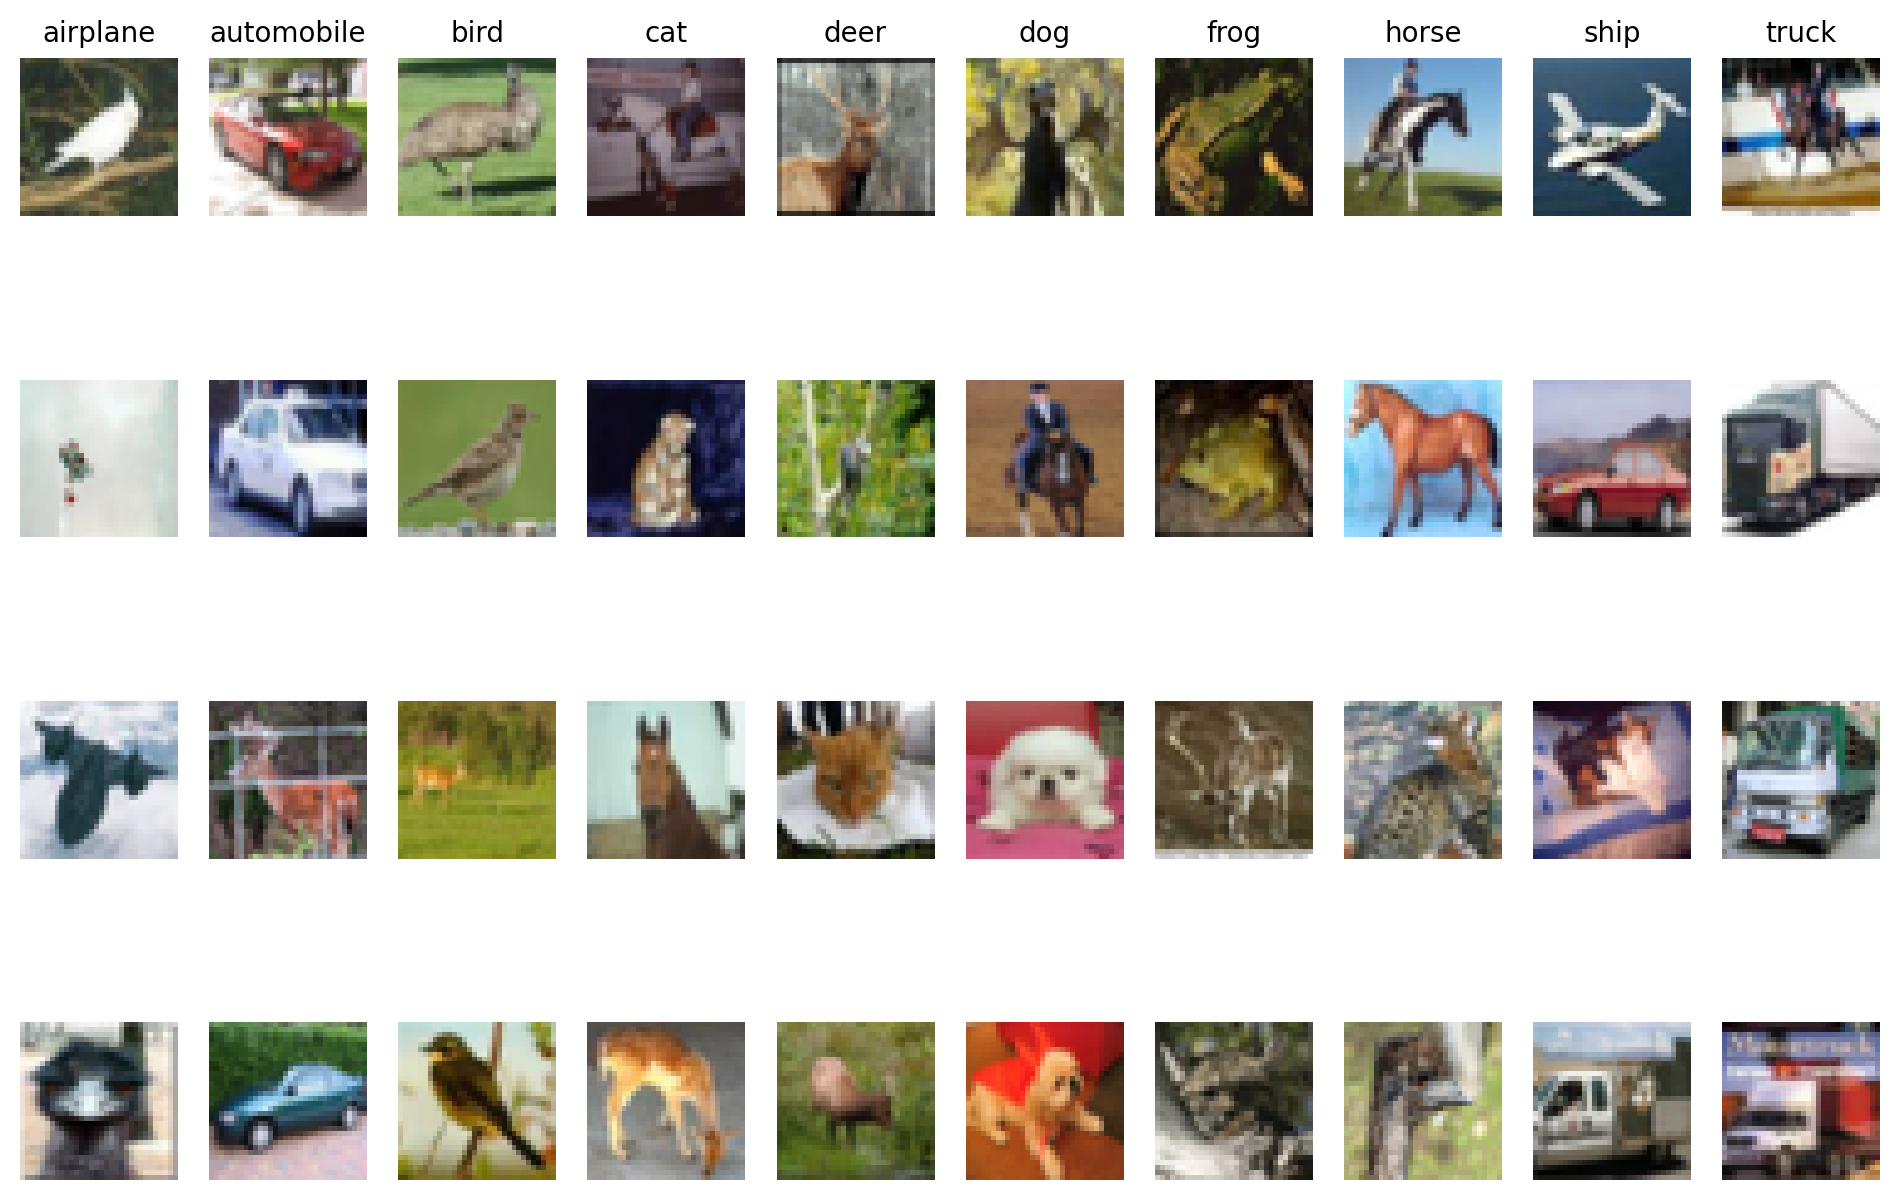

In [59]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Testing categorising on a single model

### Imports

In [60]:
import requests
from PIL import Image
from io import BytesIO

In [61]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [62]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [63]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [64]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 1s 1s/step


In [65]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [66]:
predicted_label = class_labels[predicted_class_index[0]]

In [67]:
print(predicted_label)


airplane


### <font color=maroon>Visualising confusion matrix

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [69]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [70]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.4066


In [71]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.48176523529755133
Recall: 0.4066
F1 Score: 0.38906026782163683


### Creating confusion matrix

In [72]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

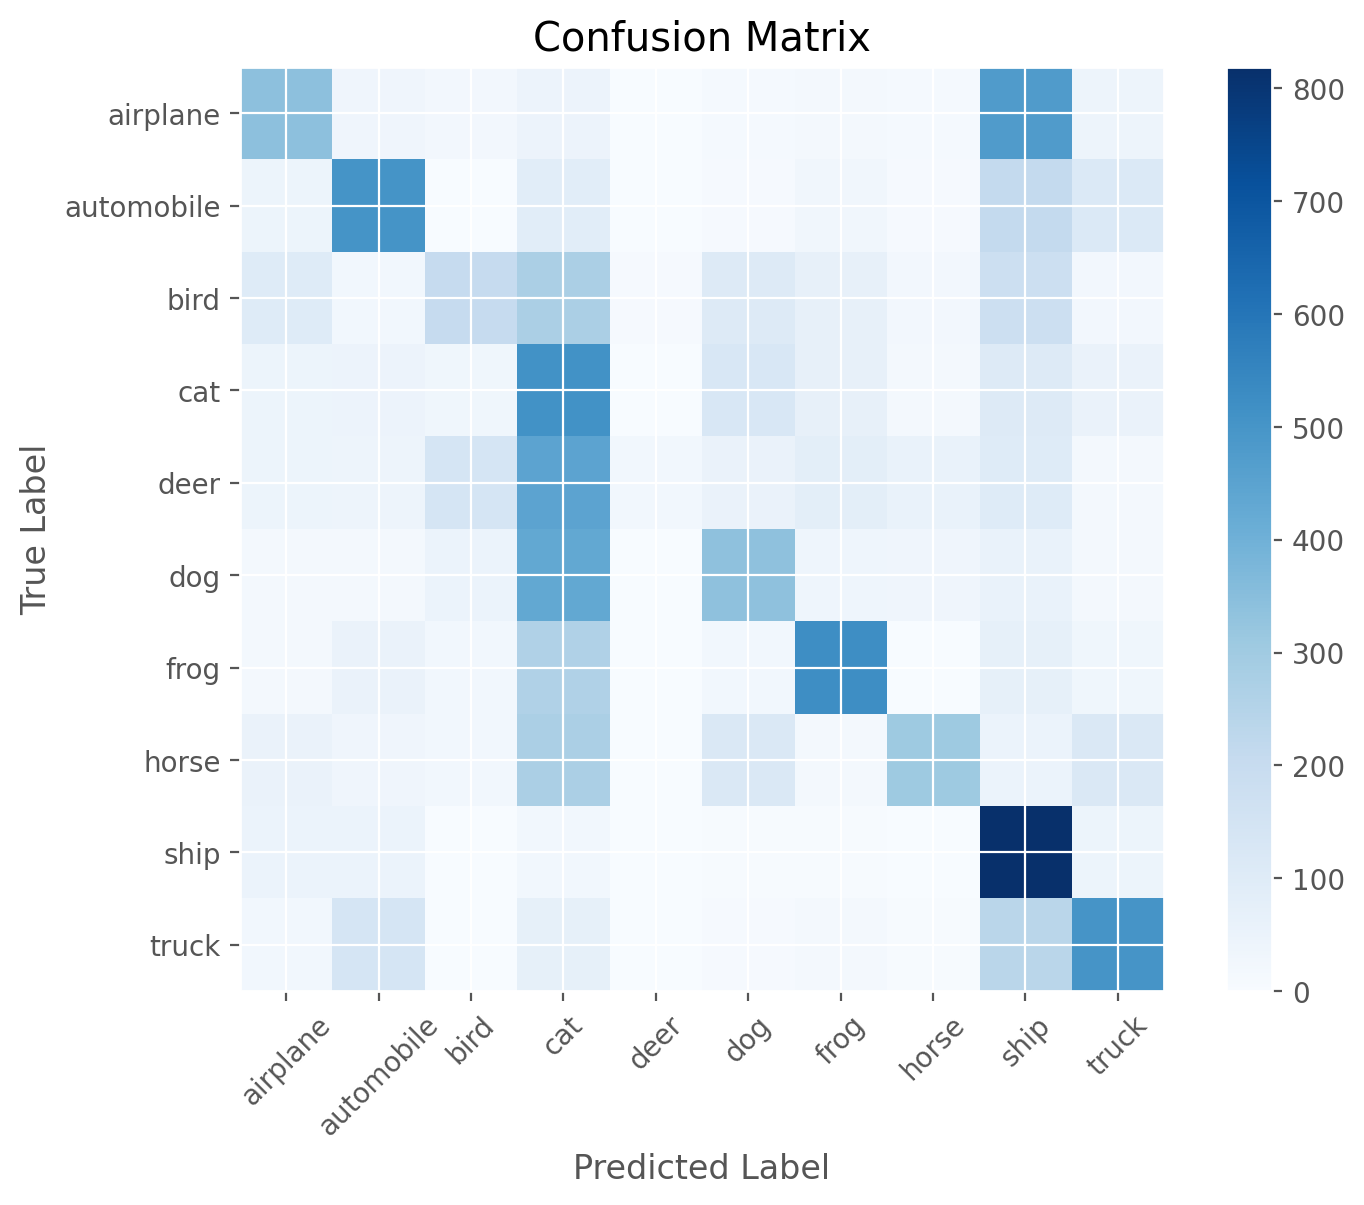

In [73]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [74]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.47      0.34      0.39      1000
  automobile       0.54      0.50      0.52      1000
        bird       0.41      0.20      0.27      1000
         cat       0.21      0.51      0.30      1000
        deer       0.62      0.02      0.04      1000
         dog       0.42      0.34      0.37      1000
        frog       0.61      0.52      0.56      1000
       horse       0.66      0.30      0.42      1000
        ship       0.36      0.82      0.50      1000
       truck       0.52      0.50      0.51      1000

    accuracy                           0.41     10000
   macro avg       0.48      0.41      0.39     10000
weighted avg       0.48      0.41      0.39     10000



# <font color=maroon>Model Building Tuned 2 - ResNet50
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>What are our parameters?</font>
- Set include top as false
- Set pre_model.trainable=False
- Added class parameter and increased dense layer number of neurons
- Reduced batch size down to 128 instead of 256 due to memory limit
- Set training = True in the layers
- 

In [4]:
pre_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', classes=10)
pre_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:
# pre_model.trainable = False
for layer in pre_model.layers: 
    layer.trainable=True

In [6]:
# build resnet50 model
model = Sequential(name='ResNet50_Baseline')
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(4098, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "ResNet50_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4098)              8396802   
                                                                 
 dense_1 (Dense)             (None, 10)                40990     
                                                                 
Total params: 32,025,504
Trainable params: 31,972,384
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/50


2023-06-02 15:46:13.784727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-02 15:46:15.562017: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 15:46:15.563226: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 15:46:15.563459: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-02 15:46:15.564667: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 15:46:15.564846: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


391/391 [==============================] - 172s 386ms/step - loss: 0.8858 - accuracy: 0.7032 - val_loss: 2.4168 - val_accuracy: 0.1002
Epoch 2/50
391/391 [==============================] - 149s 381ms/step - loss: 0.3764 - accuracy: 0.8722 - val_loss: 2.0475 - val_accuracy: 0.3133
Epoch 3/50
391/391 [==============================] - 149s 380ms/step - loss: 0.2564 - accuracy: 0.9118 - val_loss: 0.5109 - val_accuracy: 0.8350
Epoch 4/50
391/391 [==============================] - 149s 381ms/step - loss: 0.2007 - accuracy: 0.9299 - val_loss: 0.6971 - val_accuracy: 0.8055
Epoch 5/50
391/391 [==============================] - 149s 380ms/step - loss: 0.1536 - accuracy: 0.9482 - val_loss: 1.4716 - val_accuracy: 0.6925
Epoch 6/50
391/391 [==============================] - 149s 380ms/step - loss: 0.1159 - accuracy: 0.9591 - val_loss: 0.4754 - val_accuracy: 0.8634
Epoch 7/50
391/391 [==============================] - 151s 385ms/step - loss: 0.1000 - accuracy: 0.9649 - val_loss: 0.6753 - val_accura

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 9s 109ms/step - loss: 0.5898 - accuracy: 0.8989
Test loss:  0.589754581451416
Test accuracy: 0.8988999724388123


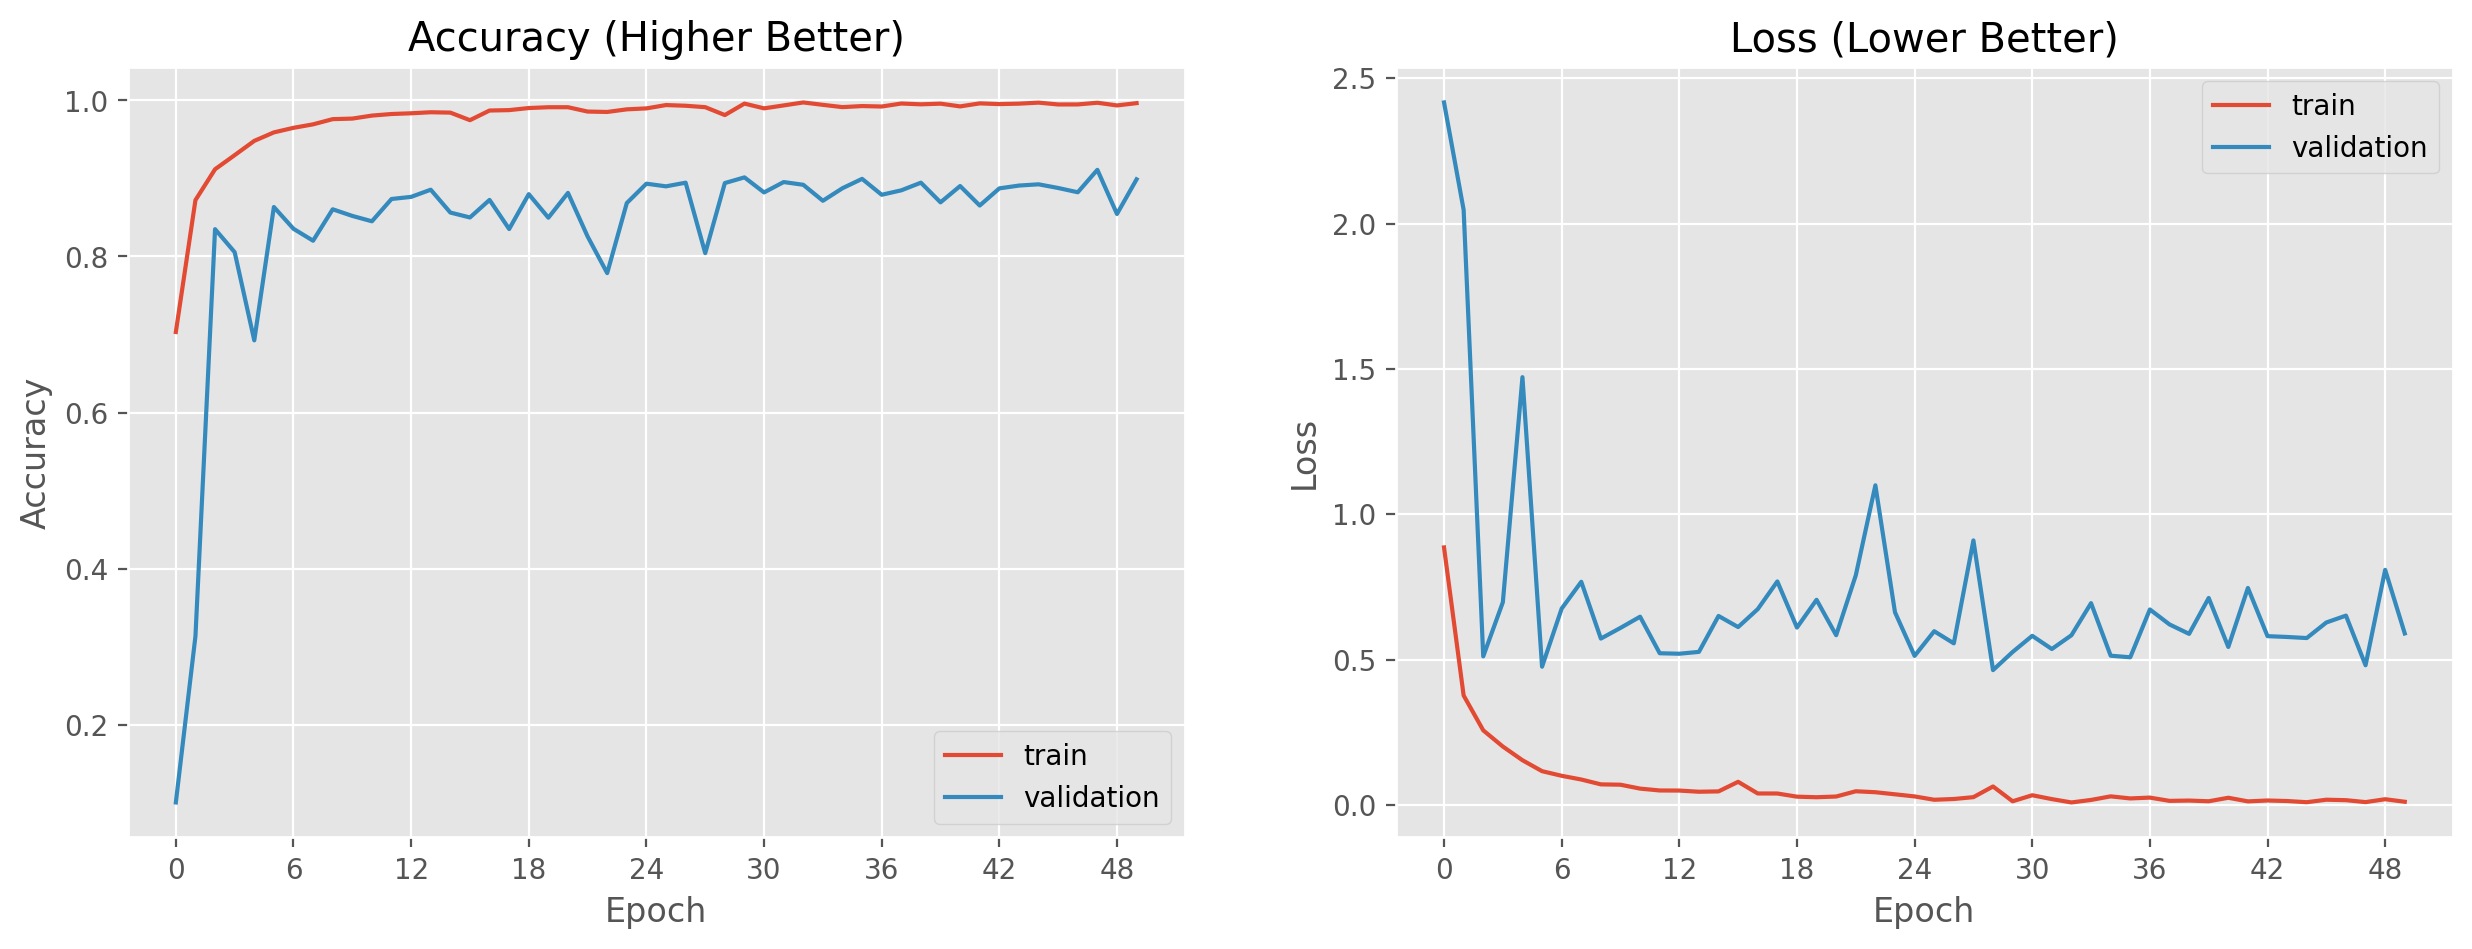

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 9s 103ms/step
[3 8 8 ... 5 1 7]


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [11]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


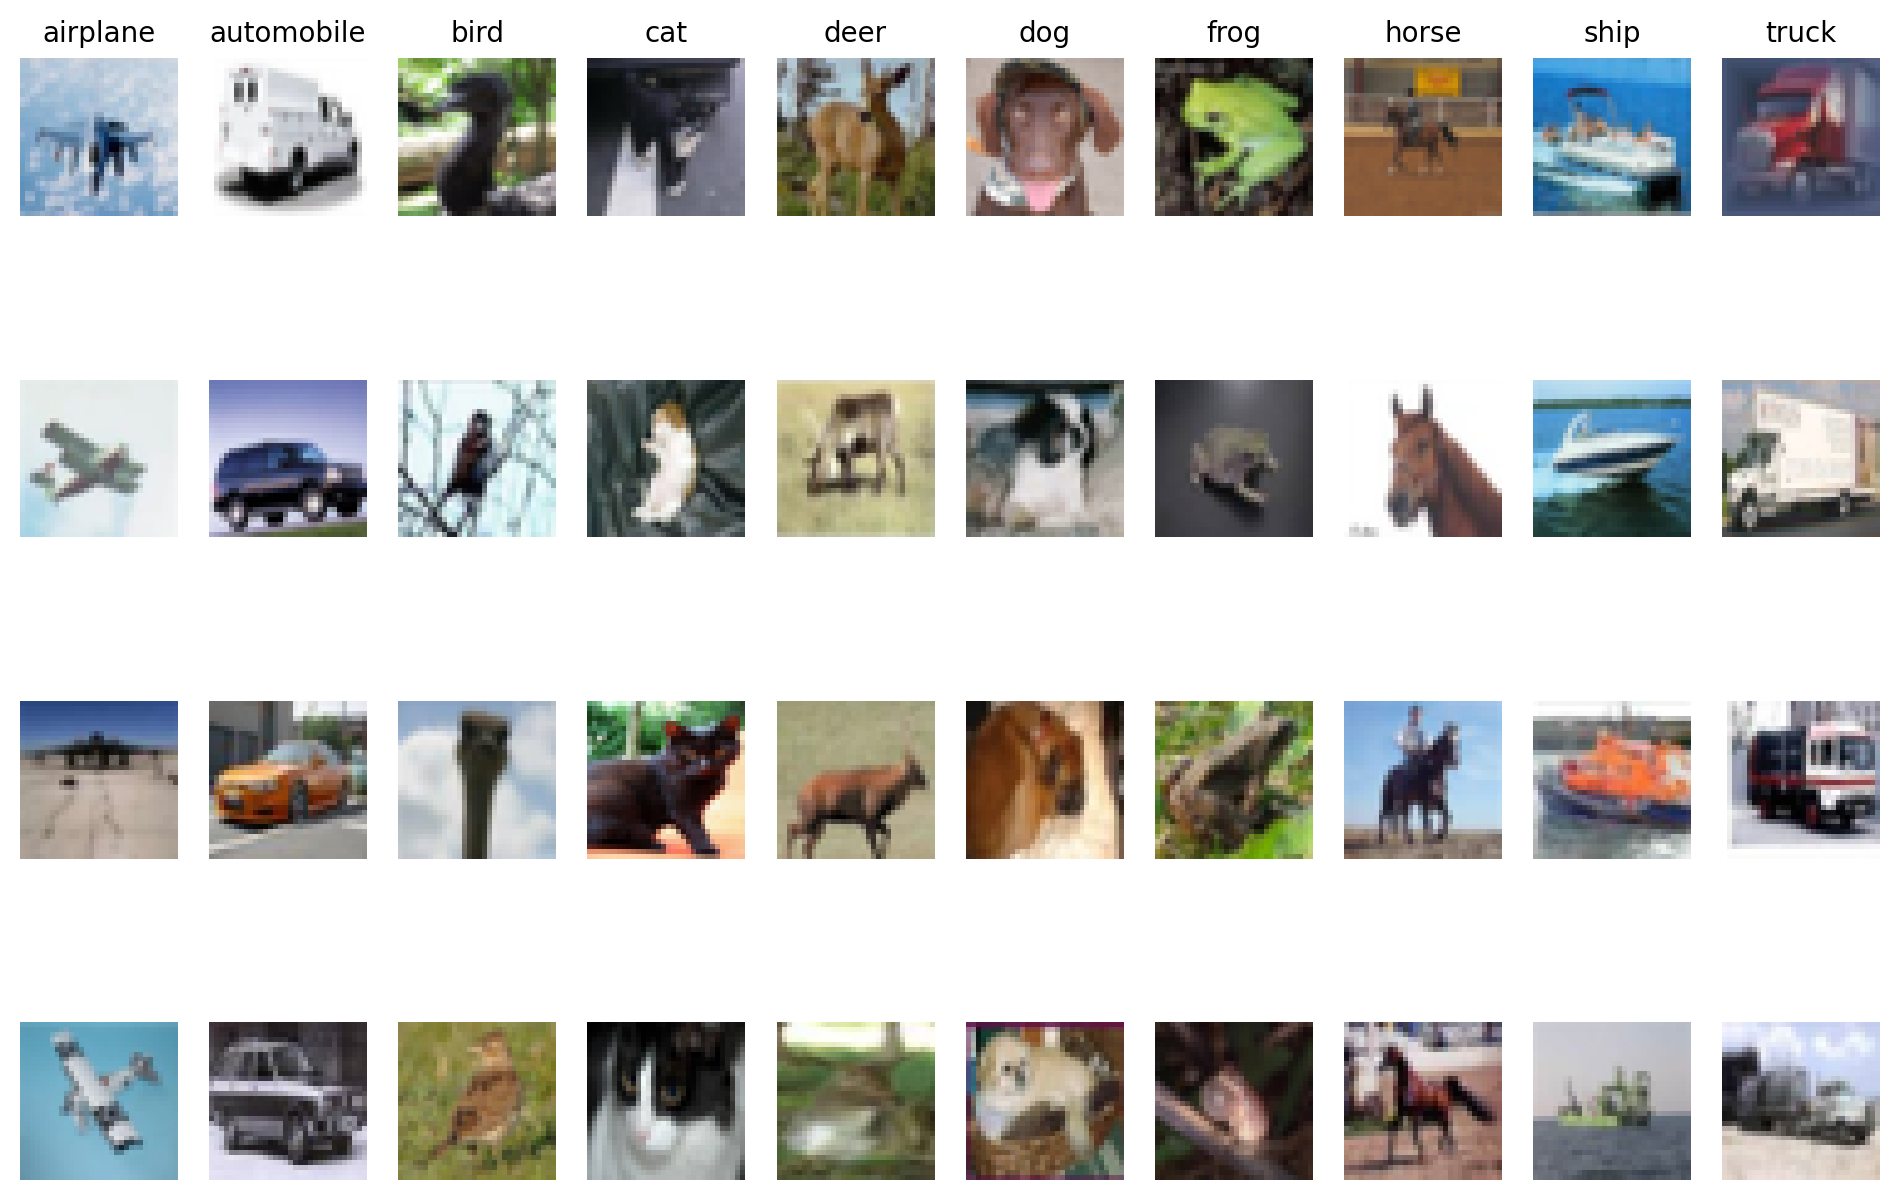

In [13]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Testing categorising on a single model

### Imports

In [14]:
import requests
from PIL import Image
from io import BytesIO

In [15]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [16]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [17]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [18]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 1s 1s/step


In [19]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [20]:
predicted_label = class_labels[predicted_class_index[0]]

In [21]:
print(predicted_label)


frog


### <font color=maroon>Visualising confusion matrix

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [23]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [24]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.8989


In [25]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.899722891520306
Recall: 0.8989
F1 Score: 0.8978704101910946


### Creating confusion matrix

In [26]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

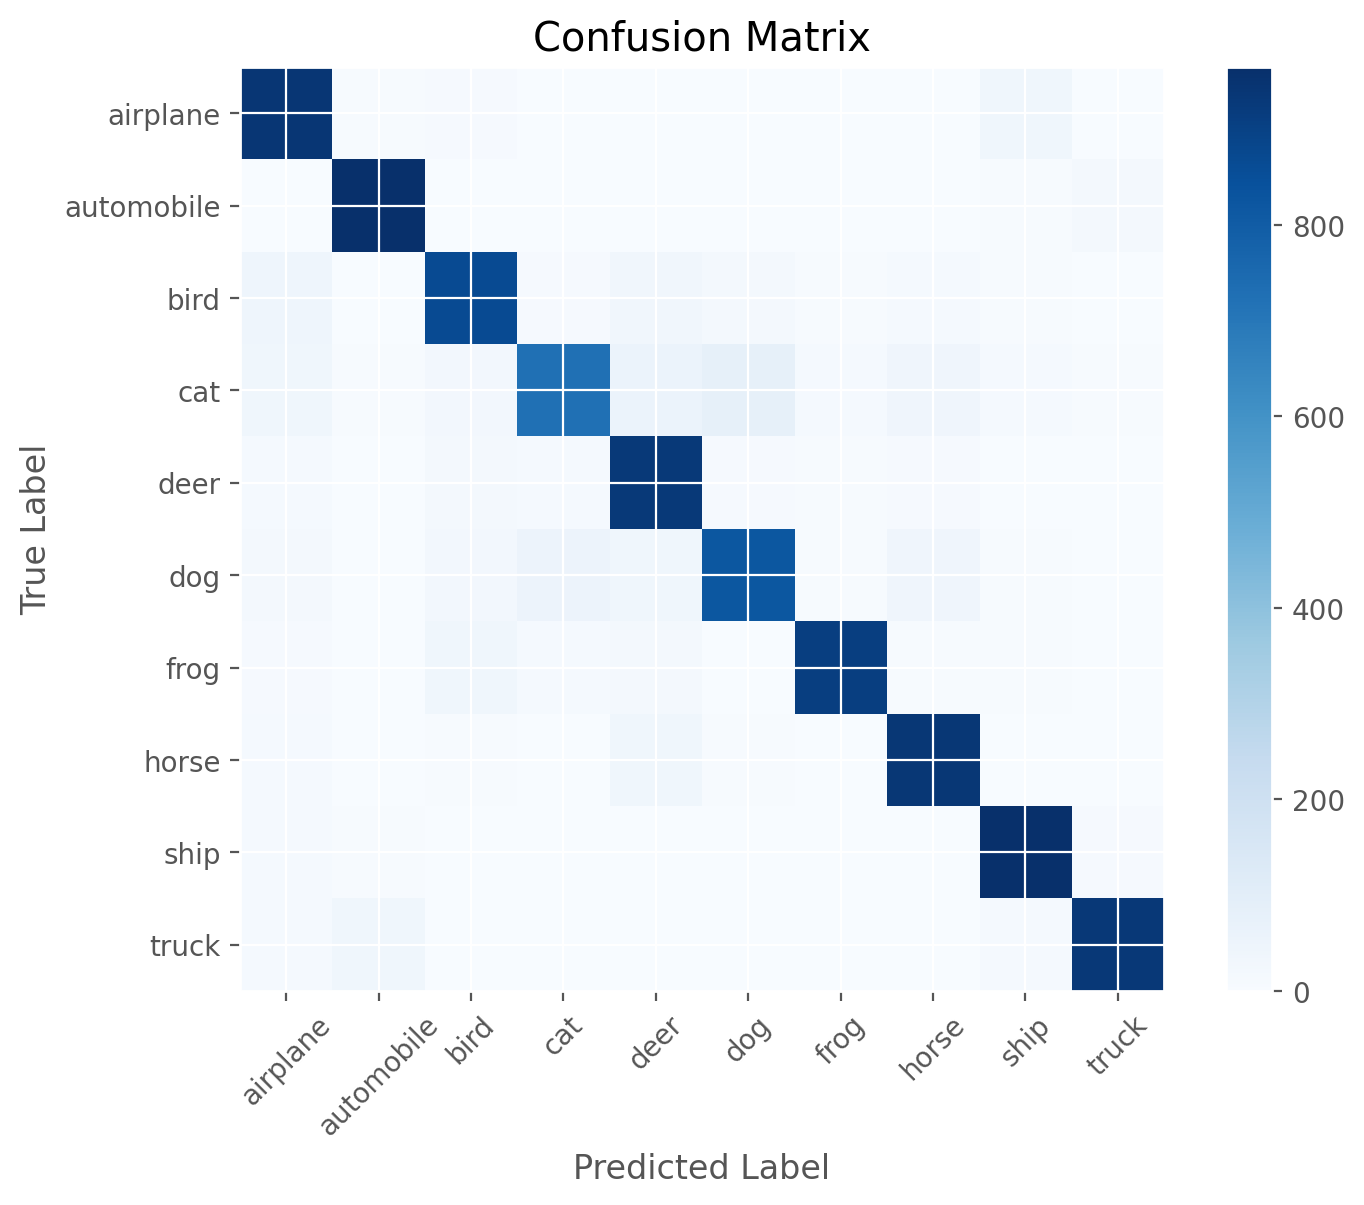

In [27]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [28]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.86      0.94      0.90      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.87      0.87      0.87      1000
         cat       0.88      0.72      0.79      1000
        deer       0.84      0.93      0.88      1000
         dog       0.87      0.82      0.84      1000
        frog       0.97      0.91      0.94      1000
       horse       0.90      0.94      0.92      1000
        ship       0.92      0.96      0.94      1000
       truck       0.96      0.93      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# <font color=maroon>Model Building Tuned 3 - ResNet50
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>What are our parameters?</font>
- Set include top as false
- Set pre_model.trainable=False
- Added class parameter and increased dense layer number of neurons
- Reduced batch size down to 128 instead of 256 due to memory limit
- Set training = True in the layers
- Added learning rate scheduler + dropout 

In [4]:
pre_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', classes=10)
pre_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:
# pre_model.trainable = False
for layer in pre_model.layers: 
    layer.trainable=True

In [7]:
# build resnet50 model
model = Sequential(name='ResNet50_Baseline')
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(4098, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)
    

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Model: "ResNet50_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 4098)              8396802   
                                                                 
 dropout_1 (Dropout)         (None, 4098)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                40990     
                                                                 
Total params: 32,025,504
Trainable params: 31,972,384
Non-trainable params: 53,120
________________________________

2023-06-02 10:17:33.245638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-02 10:17:34.771280: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 10:17:34.772674: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 10:17:34.772740: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-02 10:17:34.773726: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-02 10:17:34.773856: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


391/391 [==============================] - 165s 387ms/step - loss: 1.4485 - accuracy: 0.5108 - val_loss: 3.9807 - val_accuracy: 0.1101 - lr: 3.2258e-06
Epoch 2/50
391/391 [==============================] - 147s 375ms/step - loss: 0.5635 - accuracy: 0.8154 - val_loss: 2.4963 - val_accuracy: 0.2602 - lr: 3.2258e-06
Epoch 3/50
391/391 [==============================] - 147s 376ms/step - loss: 0.3529 - accuracy: 0.8820 - val_loss: 0.3997 - val_accuracy: 0.8628 - lr: 3.2258e-06
Epoch 4/50
391/391 [==============================] - 147s 375ms/step - loss: 0.2615 - accuracy: 0.9121 - val_loss: 0.2629 - val_accuracy: 0.9103 - lr: 3.2258e-06
Epoch 5/50
391/391 [==============================] - 146s 374ms/step - loss: 0.1993 - accuracy: 0.9329 - val_loss: 0.2461 - val_accuracy: 0.9146 - lr: 3.2258e-06
Epoch 6/50
391/391 [==============================] - 147s 376ms/step - loss: 0.1556 - accuracy: 0.9487 - val_loss: 0.2323 - val_accuracy: 0.9213 - lr: 3.2258e-06
Epoch 7/50
391/391 [=============

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 9s 109ms/step - loss: 0.2988 - accuracy: 0.9316
Test loss:  0.29883790016174316
Test accuracy: 0.9315999746322632


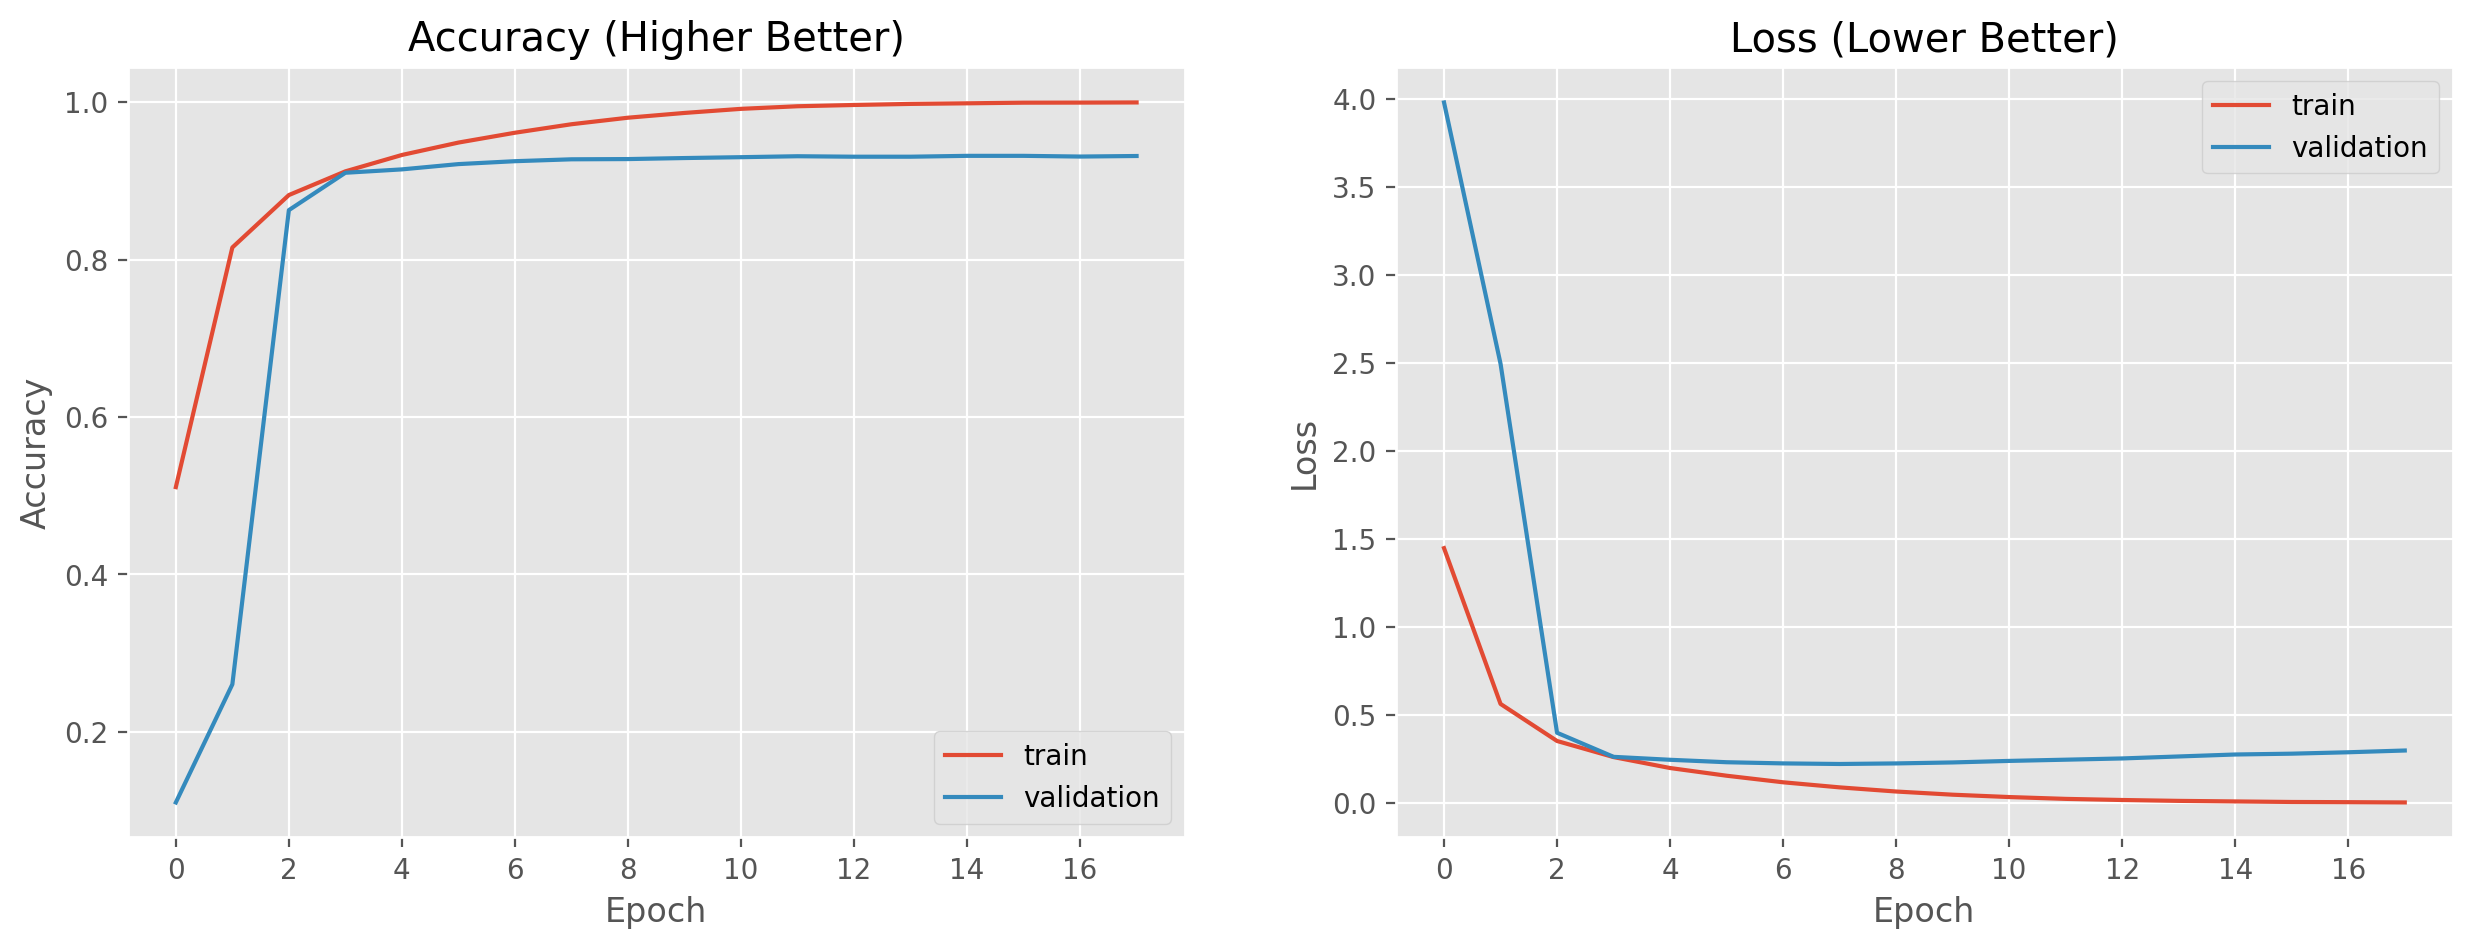

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [10]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 9s 101ms/step
[3 8 8 ... 5 1 7]


In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [12]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [13]:
print(err_x.shape)

(1000, 32, 32, 3)


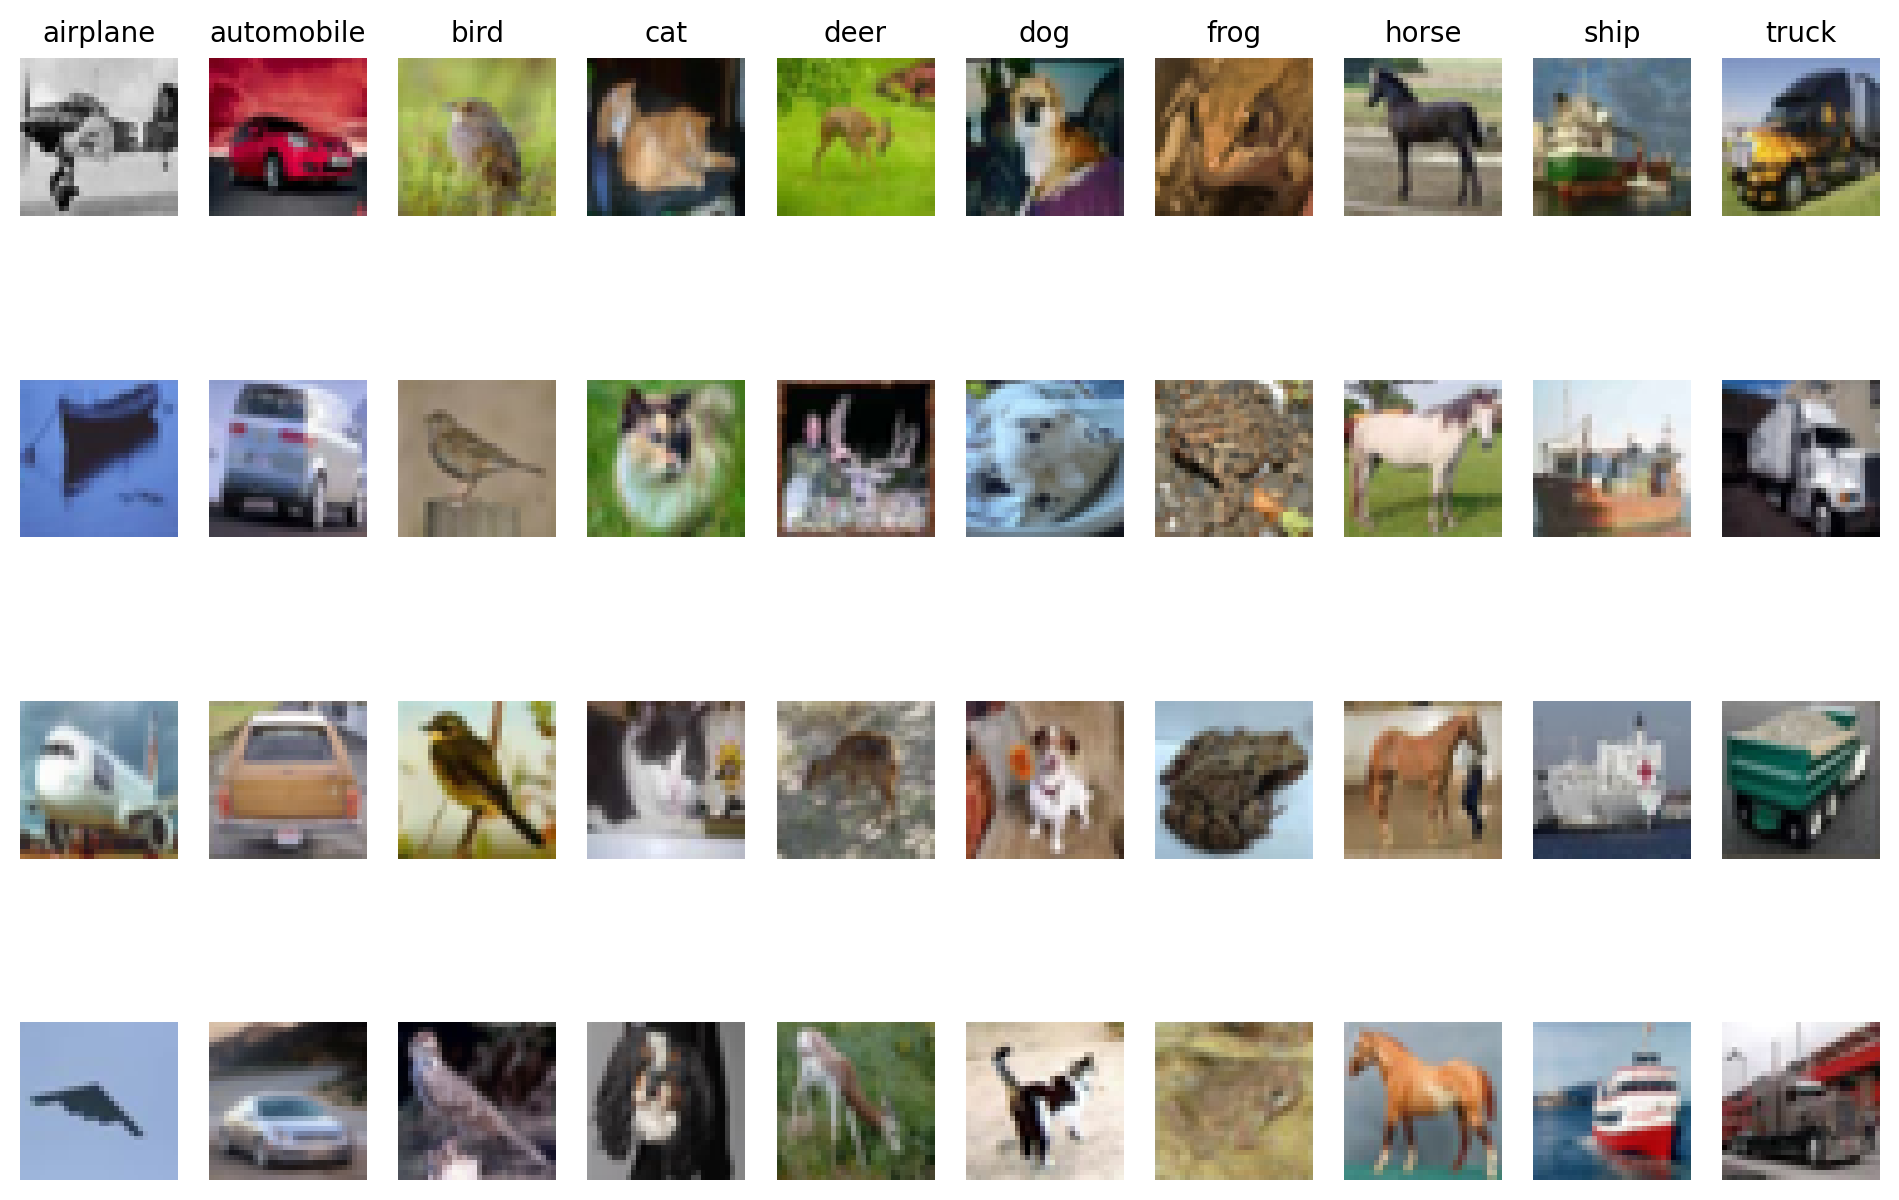

In [14]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Testing categorising on a single model

### Imports

In [31]:
import requests
from PIL import Image
from io import BytesIO

In [32]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTCZuAD92qchcnKT2KHtyFpYHtDhlKYMIxv99jzsQe1qBAdBxcSFLsncJ2UFz8rjzgGTew&usqp=CAU"  # Replace with the URL of your image

### Loading selected image from URL

In [33]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [34]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [35]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 0s 101ms/step


In [36]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [37]:
predicted_label = class_labels[predicted_class_index[0]]

In [38]:
print(predicted_label)


bird


### <font color=maroon>Visualising confusion matrix

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [40]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [41]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9316


In [42]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9317144198901655
Recall: 0.9316
F1 Score: 0.9316110958280646


### Creating confusion matrix

In [43]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

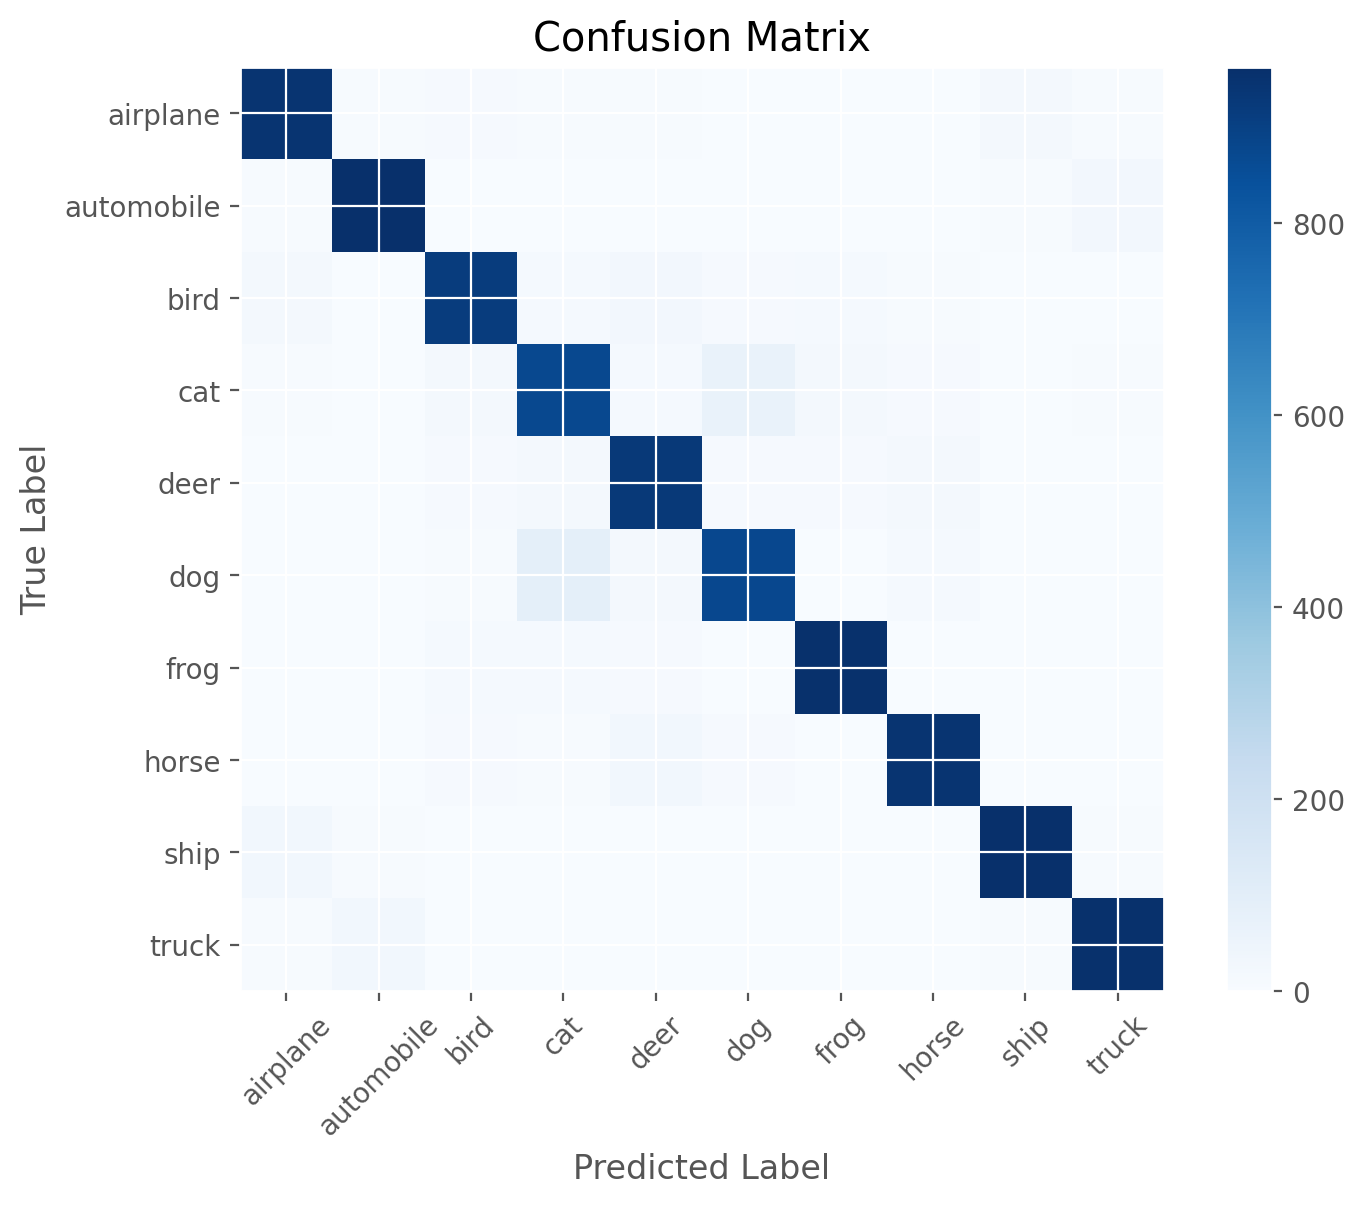

In [44]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [45]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.93      0.95      0.94      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.93      0.92      0.92      1000
         cat       0.86      0.87      0.86      1000
        deer       0.91      0.93      0.92      1000
         dog       0.90      0.87      0.89      1000
        frog       0.96      0.96      0.96      1000
       horse       0.95      0.94      0.95      1000
        ship       0.96      0.96      0.96      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [46]:
# # convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()


# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

KeyboardInterrupt: 